In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

## loading the data from csv file to Pandas DataFrame


In [2]:
big_mart_data = pd.read_csv('Train.csv')

In [3]:
big_mart_data.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228


## Six Questions ( preprocessing )


In [4]:
big_mart_data.shape

(8523, 12)

In [5]:
big_mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [6]:
big_mart_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [7]:
big_mart_data.duplicated().sum()

0

## filling missing values

- Item_Weight (filling with its mean) 
- Outlet_Type ( Filling with its mode)

In [8]:
big_mart_data['Item_Weight'].fillna(big_mart_data['Item_Weight'].mean(), inplace=True)

## filling the missing values in "Outlet_Size" column with Mode


In [9]:
# mode of "Outlet_Size" column
big_mart_data['Outlet_Size'].mode()

0    Medium
Name: Outlet_Size, dtype: object

In [10]:
big_mart_data.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [11]:
mode_of_outlet_size = big_mart_data.pivot_table(values='Outlet_Size',columns='Outlet_Type',aggfunc=lambda x: x.mode()[0])

#The values parameter specifies that we want to aggregate the Outlet_Size column. 
# The columns parameter specifies that we want to create a separate column for each unique value in the Outlet_Type column.
# The aggfunc parameter specifies the aggregation function to be used. 
# In this case, the lambda x: x.mode()[0] function is used, which finds the mode (most common value)
# of the Outlet_Size column for each group of Outlet_Type and returns the first value of the resulting series.

In [12]:
mode_of_outlet_size

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [13]:
miss_values = big_mart_data['Outlet_Size'].isnull()   

In [14]:
miss_values.value_counts()

Outlet_Size
False    6113
True     2410
Name: count, dtype: int64

In [15]:
miss_values = big_mart_data['Outlet_Size'].isnull()   
big_mart_data.loc[miss_values, 'Outlet_Size'] = big_mart_data.loc[miss_values,'Outlet_Type'].apply(lambda x: mode_of_outlet_size[x])
# This line of code is using the Pandas loc method to locate missing values in the Outlet_Size column of the big_mart_data
# dataset. 
#The miss_values variable is assumed to be a Boolean mask that filters out rows where the Outlet_Size column has
#a missing or null value.
#The code then assigns a new value to the Outlet_Size column for these missing values. 
# The new value is determined based on the corresponding value in the Outlet_Type column for each row, 
# using the mode_of_outlet_size variable as a lookup table.
# The apply() method is used to apply a function to each value in the filtered Outlet_Type column.
#In this case, the function being applied is a lambda function that takes each value of x 
#(i.e., each value in the Outlet_Type column) and looks up the corresponding value in the mode_of_outlet_size dictionary.

C:\Users\chokh\AppData\Local\Temp\ipykernel_5668\1096800727.py:2: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  big_mart_data.loc[miss_values, 'Outlet_Size'] = big_mart_data.loc[miss_values,'Outlet_Type'].apply(lambda x: mode_of_outlet_size[x])


In [16]:
# checking for missing values
big_mart_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [17]:
big_mart_data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


## EDA (Exploratory Data Analysis)


C:\Users\chokh\AppData\Local\Temp\ipykernel_5668\2446599644.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data['Item_Weight'])
C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befo

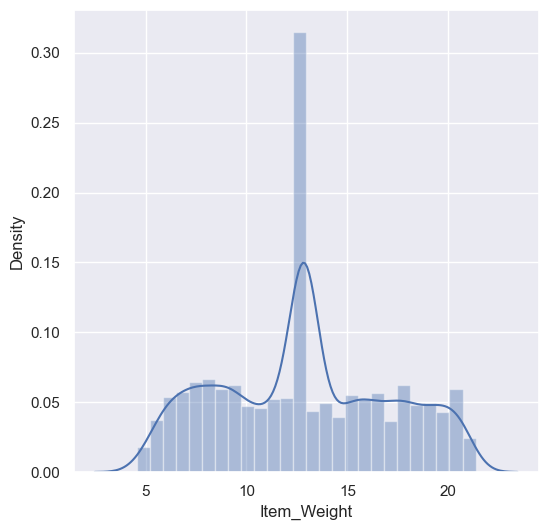

In [18]:
# Item_Weight distribution
sns.set()
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_Weight'])
plt.show()

C:\Users\chokh\AppData\Local\Temp\ipykernel_5668\193435663.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data['Item_Visibility'])
C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN b

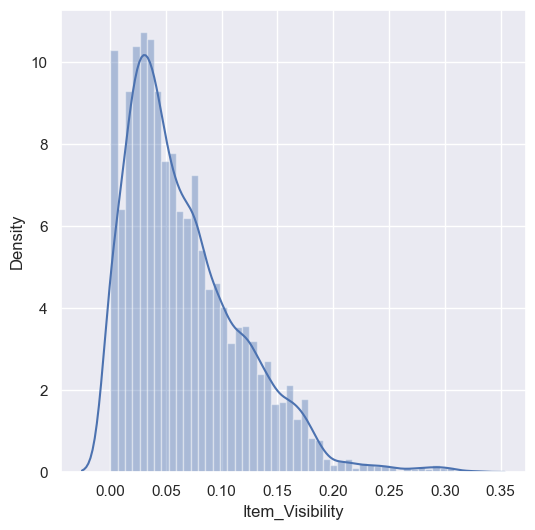

In [19]:
# Item Visibility distribution
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_Visibility'])
plt.show()

C:\Users\chokh\AppData\Local\Temp\ipykernel_5668\1610987680.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data['Item_MRP'])
C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before 

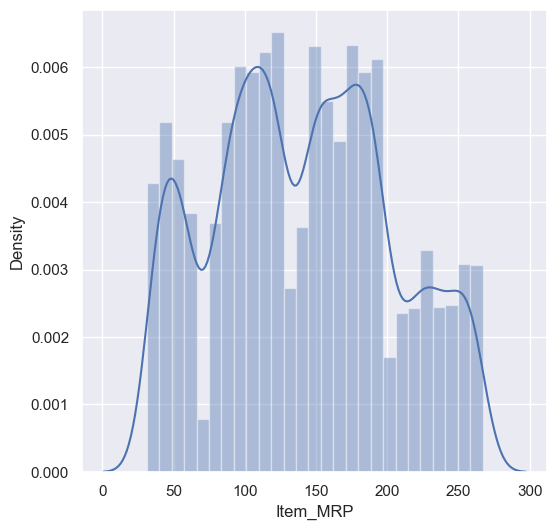

In [20]:
# Item MRP distribution
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_MRP'])
plt.show()

C:\Users\chokh\AppData\Local\Temp\ipykernel_5668\1323853436.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(big_mart_data['Item_Outlet_Sales'])
C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to Na

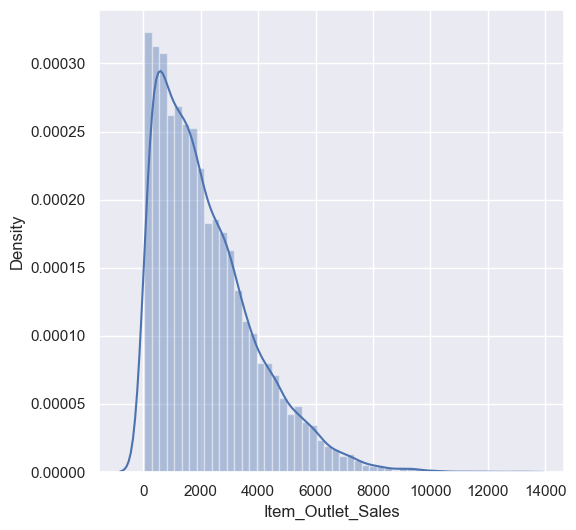

In [21]:
# Item_Outlet_Sales distribution
plt.figure(figsize=(6,6))
sns.distplot(big_mart_data['Item_Outlet_Sales'])
plt.show()

C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


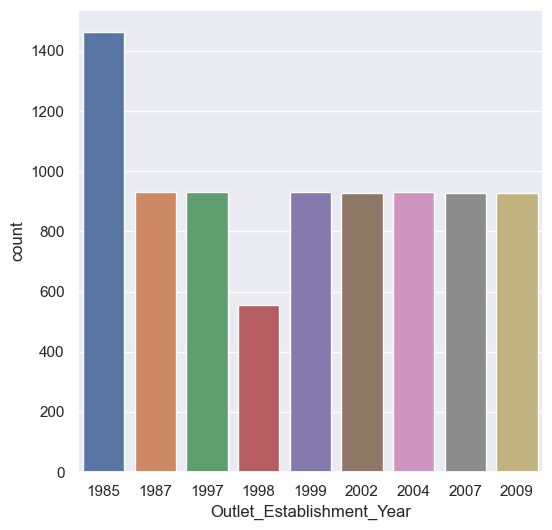

In [22]:
# Outlet_Establishment_Year column
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Establishment_Year', data=big_mart_data)
plt.show()

C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


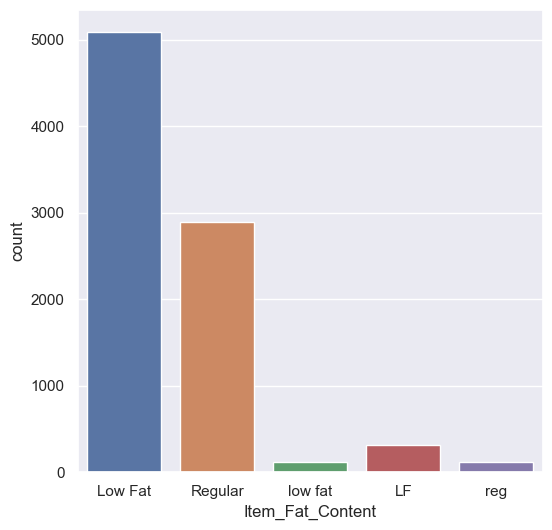

In [23]:
# Item_Fat_Content column
plt.figure(figsize=(6,6))
sns.countplot(x='Item_Fat_Content', data=big_mart_data)
plt.show()

C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


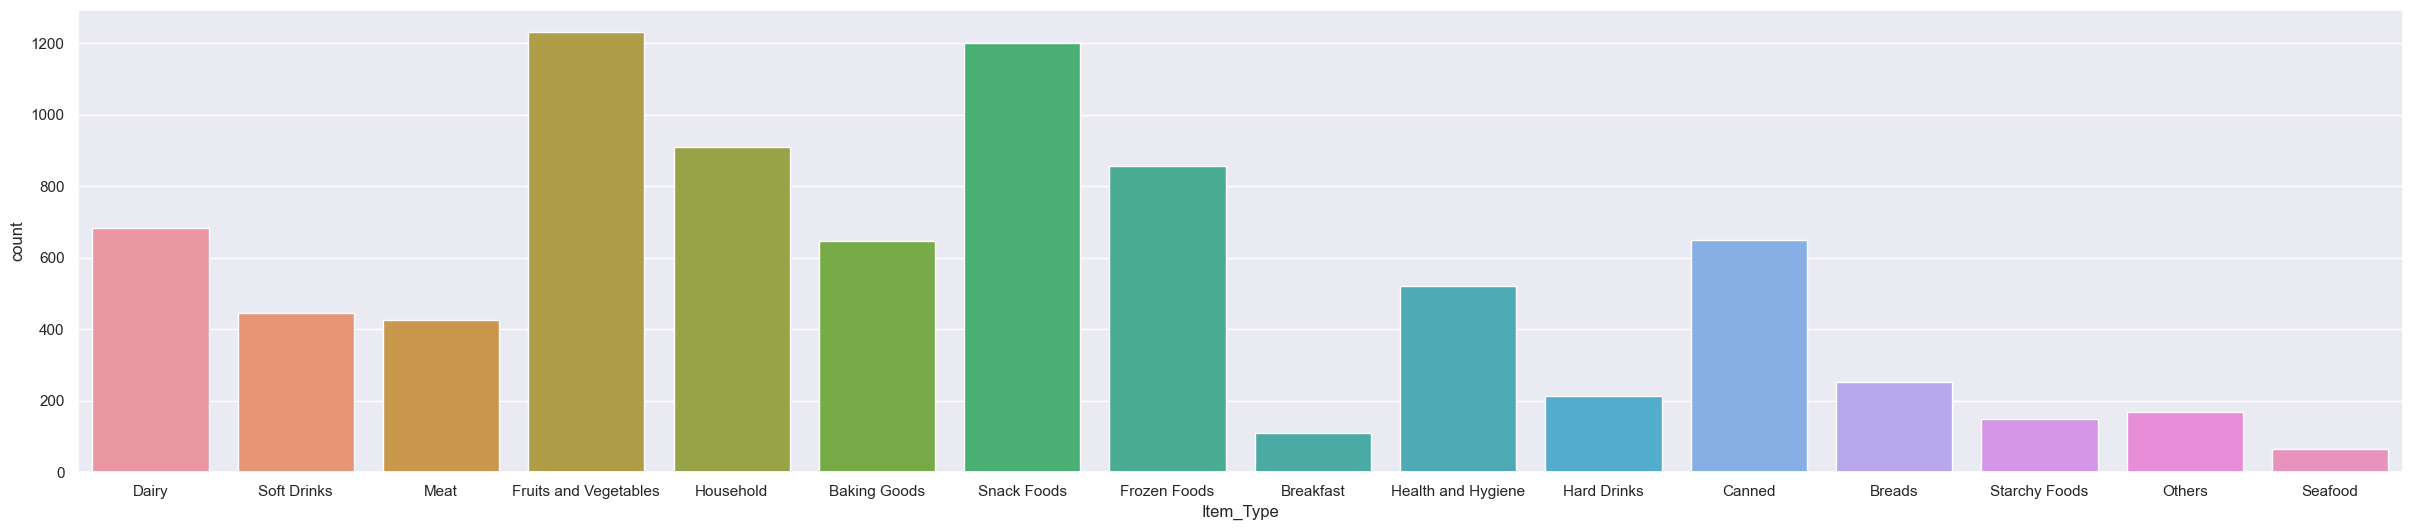

In [28]:
# Item_Type column
plt.figure(figsize=(30,6))
sns.countplot(x='Item_Type', data=big_mart_data)
plt.show()

C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


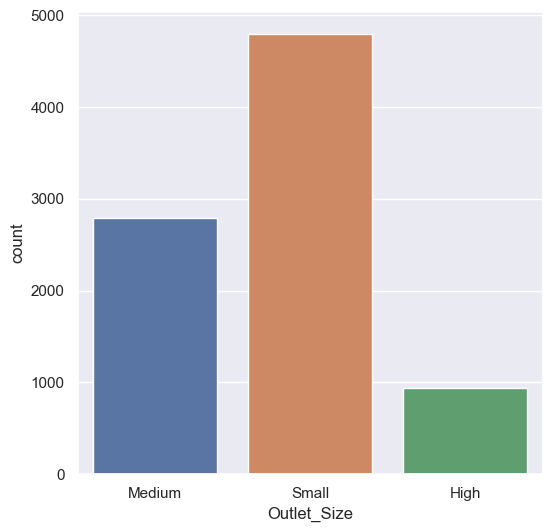

In [29]:
# Outlet_Size column
plt.figure(figsize=(6,6))
sns.countplot(x='Outlet_Size', data=big_mart_data)
plt.show()

In [30]:
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [31]:
# big_mart_data['Item_Fat_Content'].value_counts()
big_mart_data.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}}, inplace=True)

## Label Encoding


In [32]:
encoder = LabelEncoder()

In [33]:
big_mart_data['Item_Identifier'] = encoder.fit_transform(big_mart_data['Item_Identifier'])

big_mart_data['Item_Fat_Content'] = encoder.fit_transform(big_mart_data['Item_Fat_Content'])

big_mart_data['Item_Type'] = encoder.fit_transform(big_mart_data['Item_Type'])

big_mart_data['Outlet_Identifier'] = encoder.fit_transform(big_mart_data['Outlet_Identifier'])

big_mart_data['Outlet_Size'] = encoder.fit_transform(big_mart_data['Outlet_Size'])

big_mart_data['Outlet_Location_Type'] = encoder.fit_transform(big_mart_data['Outlet_Location_Type'])

big_mart_data['Outlet_Type'] = encoder.fit_transform(big_mart_data['Outlet_Type'])

In [34]:
big_mart_data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,156,9.30,0,0.016047,4,249.8092,9,1999,1,0,1,3735.1380
1,8,5.92,1,0.019278,14,48.2692,3,2009,1,2,2,443.4228
2,662,17.50,0,0.016760,10,141.6180,9,1999,1,0,1,2097.2700
3,1121,19.20,1,0.000000,6,182.0950,0,1998,2,2,0,732.3800
4,1297,8.93,0,0.000000,9,53.8614,1,1987,0,2,1,994.7052


## Splitting Data Into Test and Train Parts


In [35]:
X = big_mart_data.drop(columns='Item_Outlet_Sales', axis=1)
Y = big_mart_data['Item_Outlet_Sales']

In [36]:
X.shape

(8523, 11)

In [37]:
Y.shape

(8523,)

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

## Machine Learning Model Training

XGBoost Regressor




In [39]:
regressor = XGBRegressor()
regressor.fit(X_train,Y_train)
y_pred = regressor.predict(X_test)

C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\chokh\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:336: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

In [40]:
metrics.r2_score(Y_test, y_pred)

0.5233136709735687

In [41]:
big_mart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   int32  
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   int32  
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   int32  
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   int32  
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   int32  
 9   Outlet_Location_Type       8523 non-null   int32  
 10  Outlet_Type                8523 non-null   int32  
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int32(7), int64(1)
memory usage: 566.1 KB


In [42]:
big_mart_data.sample(4)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
4920,697,8.00,1,0.050657,1,249.9092,0,1998,2,2,0,249.0092
8380,480,15.10,0,0.000000,10,244.2512,7,2002,2,1,1,3635.2680
7336,1262,6.63,1,0.104445,0,167.2500,3,2009,1,2,2,1830.9500
7956,793,15.70,0,0.074083,0,253.3724,2,2007,2,1,1,6795.1548


## Sales Prediction System


In [43]:
# 677,19.35,1,0.065891,10,167.0816,2,2007,2,1,1
# 250,6.89,1,0.136428,13,193.9820,8,1997,2,0,1


input = (250,6.89,1,0.136428,13,193.9820,8,1997,2,0,1)
new_input = np.asanyarray(input,dtype=float)
prediciton = regressor.predict(new_input.reshape(1,-1))
print(prediciton)

[2743.2356]


In [44]:
import pickle
pickle.dump(regressor,open('model.pkl','wb'))